In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import all the necessary libraries for the project.
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import shutil
import numpy as np
import gdown
from zipfile import ZipFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# --- Download the dataset from Google Drive ---
print("Downloading dataset...")
# The Google Drive file ID for the Thyroid Dataset
file_id = '1reHyY5eTZ5uePXMVMzFOq5j3eFOSp50F'
output_zip_path = 'Thyroid_Dataset.zip'
gdown.download(id=file_id, output=output_zip_path, quiet=False)
print("Download complete.")

# --- Unzip the dataset ---
print("Unzipping dataset...")
with ZipFile(output_zip_path, 'r') as zip_ref:
    zip_ref.extractall('Thyroid_Data')
print("Unzipping complete.")

# --- Create directory structure ---
print("Creating Train/Test directories...")
# Define base paths
base_path = 'data'
train_path = os.path.join(base_path, 'Train')
test_path = os.path.join(base_path, 'Test')

# Create directories, removing old ones if they exist
if os.path.exists(base_path):
    shutil.rmtree(base_path)

os.makedirs(os.path.join(train_path, 'Images'), exist_ok=True)
os.makedirs(os.path.join(train_path, 'Masks'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'Images'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'Masks'), exist_ok=True)
print("Directory structure created.")


# --- Split data into Train and Test sets ---
# Define original data paths
path_img_folder = 'Thyroid_Data/Thyroid Dataset/tg3k/thyroid-image/'
path_mask_folder = 'Thyroid_Data/Thyroid Dataset/tg3k/thyroid-mask/'

image_files = sorted(os.listdir(path_img_folder))
mask_files = sorted(os.listdir(path_mask_folder))

# Create a shuffled index for splitting
indices = list(range(len(image_files)))
np.random.shuffle(indices)

# Define split point (e.g., 70% train, 30% test)
split_point = int(0.7 * len(image_files))
train_indices = indices[:split_point]
test_indices = indices[split_point:]

# Move files to the new directories
print("Splitting and moving files...")
for idx in train_indices:
    shutil.copy(os.path.join(path_img_folder, image_files[idx]), os.path.join(train_path, 'Images', image_files[idx]))
    shutil.copy(os.path.join(path_mask_folder, mask_files[idx]), os.path.join(train_path, 'Masks', mask_files[idx]))

for idx in test_indices:
    shutil.copy(os.path.join(path_img_folder, image_files[idx]), os.path.join(test_path, 'Images', image_files[idx]))
    shutil.copy(os.path.join(path_mask_folder, mask_files[idx]), os.path.join(test_path, 'Masks', mask_files[idx]))

print(f"Data split complete. {len(train_indices)} training samples, {len(test_indices)} testing samples.")

Downloading...
From (original): https://drive.google.com/uc?id=1reHyY5eTZ5uePXMVMzFOq5j3eFOSp50F
From (redirected): https://drive.google.com/uc?id=1reHyY5eTZ5uePXMVMzFOq5j3eFOSp50F&confirm=t&uuid=33b4322c-a15e-4445-b4fe-9b844ac1026f
To: /content/Thyroid_Dataset.zip
100%|██████████| 395M/395M [00:06<00:00, 61.5MB/s]


Download complete.
Unzipping dataset...
Unzipping complete.
Creating Train/Test directories...
Directory structure created.
Splitting and moving files...
Data split complete. 2509 training samples, 1076 testing samples.


In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        # Create sorted lists of image and mask filenames
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Use the separate lists to get the correct image and mask paths
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Load image and mask in grayscale format
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# --- Define Transforms and Create DataLoaders ---
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = SegmentationDataset(
    image_dir=os.path.join(train_path, 'Images'),
    mask_dir=os.path.join(train_path, 'Masks'),
    transform=data_transforms
)
test_dataset = SegmentationDataset(
    image_dir=os.path.join(test_path, 'Images'),
    mask_dir=os.path.join(test_path, 'Masks'),
    transform=data_transforms
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print("DataLoaders are ready.")

DataLoaders are ready.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Residual U-Net Building Block ---
class ResidualBlock(nn.Module):
    """
    A block incorporating a residual connection (identity mapping)
    to the output of a two-convolution layer sequence.
    """
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Shortcut layer to match dimensions if in_channels != out_channels
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        # 1. Compute the residual path
        residual = x if self.shortcut is None else self.shortcut(x)

        # 2. Compute the main path
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # 3. Add the residual (skip connection)
        out += residual

        # 4. Final activation
        return self.relu(out)

# --- Residual U-Net Architecture ---
class UNetWithResiduals(nn.Module):
    """
    U-Net architecture where the standard convolutional blocks are
    replaced with ResidualBlocks.
    """
    def __init__(self, n_classes=1):
        super(UNetWithResiduals, self).__init__()

        # Encoder (Downsampling Path)
        self.enc1 = ResidualBlock(1, 64)    # Input: 1 channel (grayscale image)
        self.enc2 = ResidualBlock(64, 128)
        self.enc3 = ResidualBlock(128, 256)
        self.bottleneck = ResidualBlock(256, 512)

        # Decoder (Upsampling Path)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        # Note: input channels is 512 (256 from upconv + 256 from enc3 skip)
        self.dec3 = ResidualBlock(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        # Note: input channels is 256 (128 from upconv + 128 from enc2 skip)
        self.dec2 = ResidualBlock(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        # Note: input channels is 128 (64 from upconv + 64 from enc1 skip)
        self.dec1 = ResidualBlock(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        bottleneck = self.bottleneck(F.max_pool2d(enc3, 2))

        # Decoder
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1) # Skip connection
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1) # Skip connection
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1) # Skip connection
        dec1 = self.dec1(dec1)

        # Output (Sigmoid for binary segmentation)
        return torch.sigmoid(self.final_conv(dec1))

In [6]:
# --- GPU Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda



# ----------------------------------------------------------------------
# S T E P 6 : M O D E L T R A I N I N G (Residual U-Net Only)
# ----------------------------------------------------------------------

--- Starting Training for Residual U-Net ---
Epoch 1/20 -> Train Loss: 0.1710, Test Dice: 0.7978
  -> New best model saved with Dice score: 0.7978
Epoch 2/20 -> Train Loss: 0.0501, Test Dice: 0.8744
  -> New best model saved with Dice score: 0.8744
Epoch 3/20 -> Train Loss: 0.0348, Test Dice: 0.9146
  -> New best model saved with Dice score: 0.9146
Epoch 4/20 -> Train Loss: 0.0287, Test Dice: 0.9234
  -> New best model saved with Dice score: 0.9234
Epoch 5/20 -> Train Loss: 0.0229, Test Dice: 0.9280
  -> New best model saved with Dice score: 0.9280
Epoch 6/20 -> Train Loss: 0.0194, Test Dice: 0.9451
  -> New best model saved with Dice score: 0.9451
Epoch 7/20 -> Train Loss: 0.0168, Test Dice: 0.9527
  -> New best model saved with Dice score: 0.9527
Epoch 8/20 -> Train Loss: 0.015

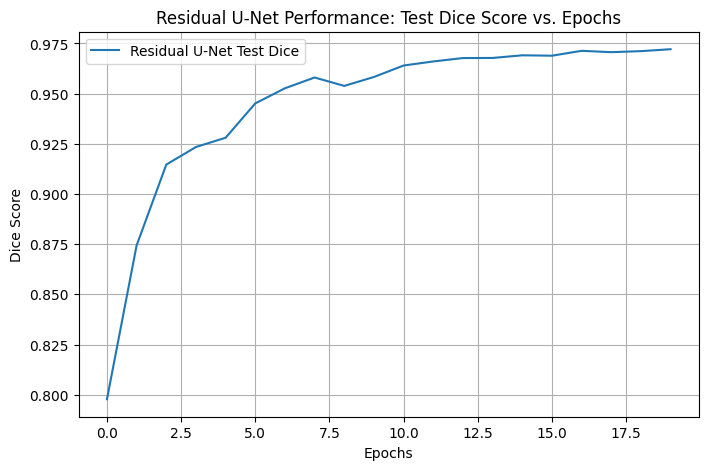


Visualizing predictions for Residual U-Net...


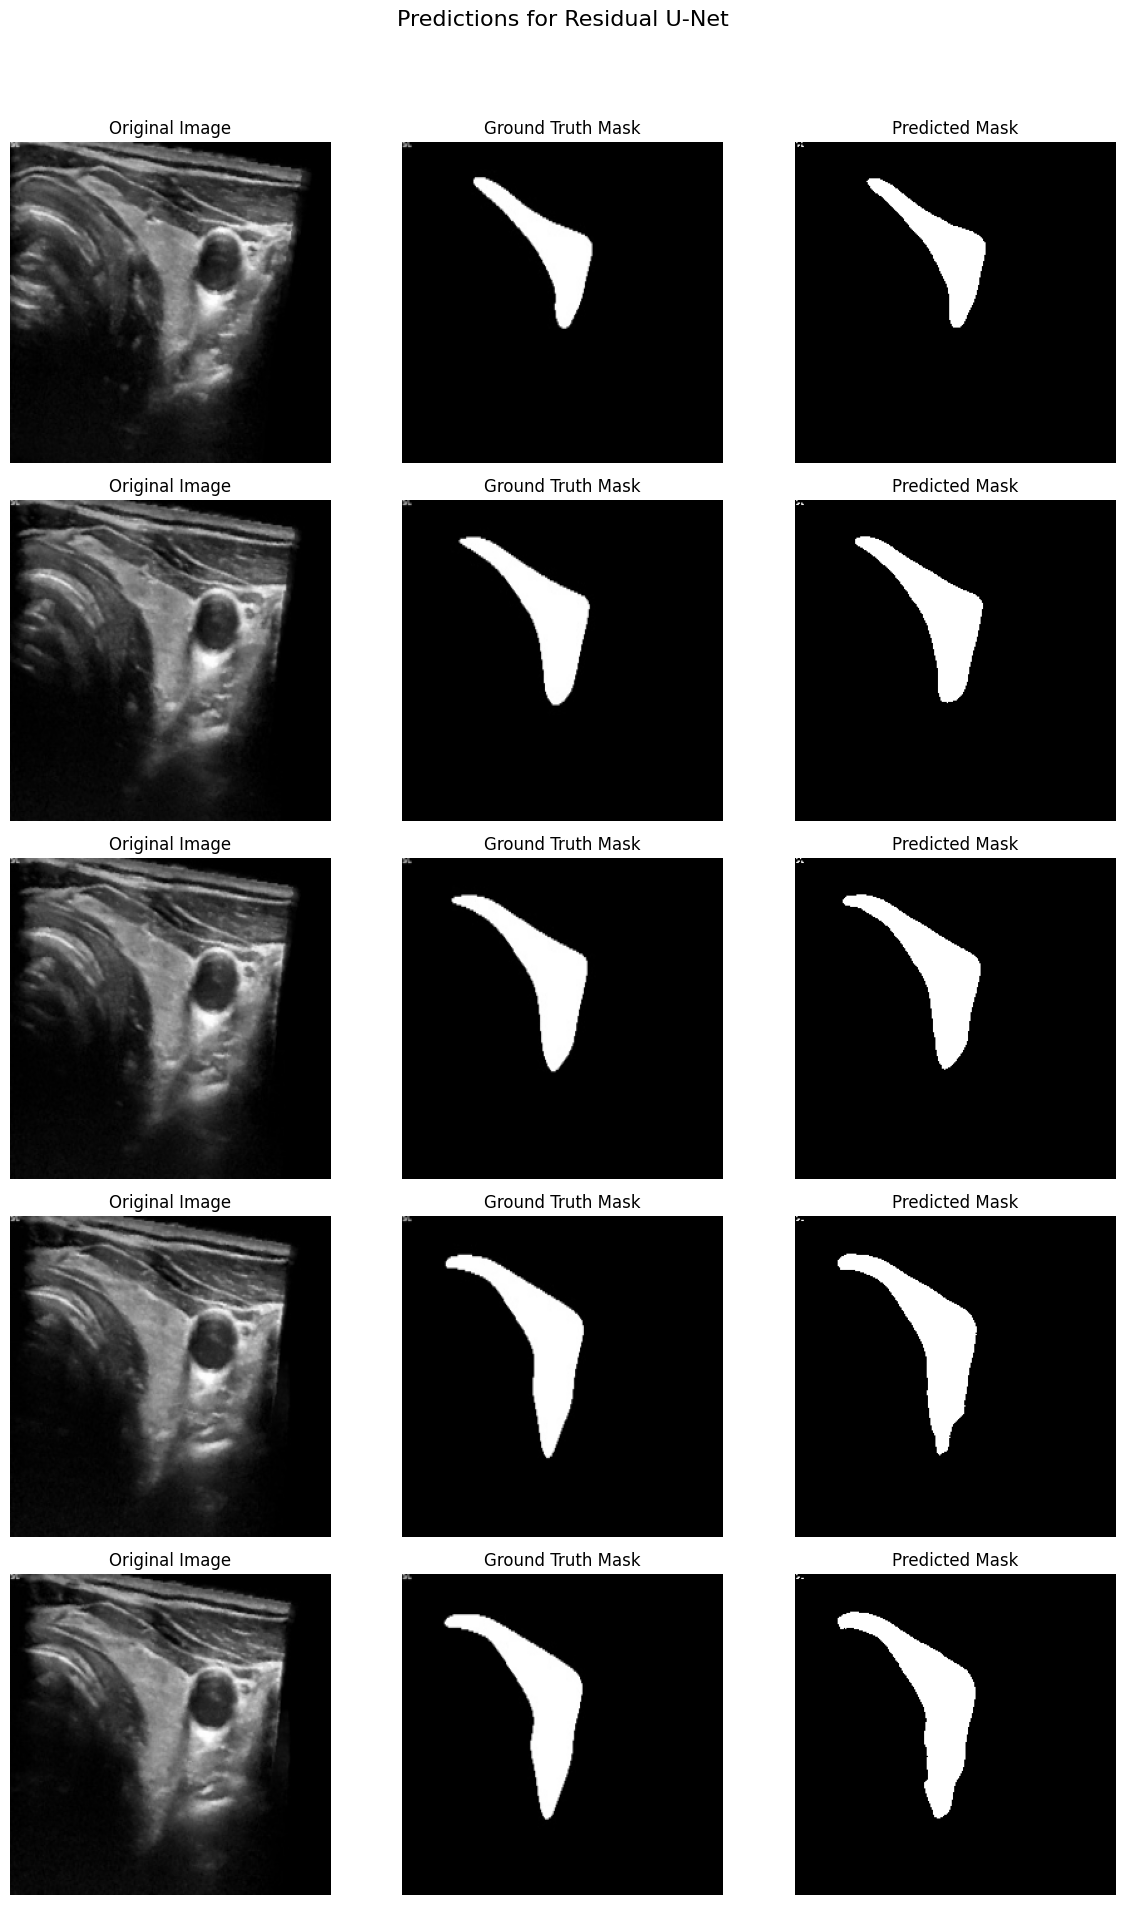

In [7]:
# --- Training and Evaluation Functions ---
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, masks in loader:
        # Assuming train_loader is defined externally
        images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def dice_coefficient(preds, targets, smooth=1e-6):
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def evaluate_model(model, loader):
    model.eval()
    total_dice = 0.0
    with torch.no_grad():
        for images, masks in loader:
            # Assuming test_loader is defined externally
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
            outputs = model(images)
            total_dice += dice_coefficient(outputs, masks).item()
    return total_dice / len(loader)

def visualize_predictions(model, loader, model_name, num_images=5):
    model.eval()
    # Safely get a batch of data (assumes `loader` is test_loader)
    try:
        images, masks = next(iter(loader))
    except StopIteration:
        print("DataLoader is empty or exhausted.")
        return

    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = (outputs > 0.5).float()

    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
    fig.suptitle(f'Predictions for {model_name}', fontsize=16)
    for i in range(num_images):
        # Ensure we don't index beyond the batch size
        if i >= images.size(0):
            break

        axes[i, 0].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(preds[i].cpu().squeeze(), cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("\n# ----------------------------------------------------------------------")
print("# S T E P 6 : M O D E L T R A I N I N G (Residual U-Net Only)")
print("# ----------------------------------------------------------------------")

# --- Initialize Model, Optimizer, and Loss Function ---
model_name = "Residual U-Net"
model_resunet = UNetWithResiduals().to(device)
optimizer_resunet = torch.optim.Adam(model_resunet.parameters(), lr=1e-4)
criterion = nn.BCELoss() # Binary Cross Entropy Loss

history = {'train_loss': [], 'test_dice': []}
num_epochs = 20 # Set number of epochs for training
model_filename = 'best_residual_u_net_model.pth'

print(f"\n--- Starting Training for {model_name} ---")
best_dice = 0.0

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model_resunet, train_loader, optimizer_resunet, criterion)
    test_dice = evaluate_model(model_resunet, test_loader)

    history['train_loss'].append(train_loss)
    history['test_dice'].append(test_dice)

    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Test Dice: {test_dice:.4f}")

    # Save the best performing model
    if test_dice > best_dice:
        best_dice = test_dice
        torch.save(model_resunet.state_dict(), model_filename)
        print(f"  -> New best model saved with Dice score: {best_dice:.4f}")

print(f"\nTraining for {model_name} complete.")


print("\n# ----------------------------------------------------------------------")
print("# S T E P 7 : F I N A L R E S U L T S A N D V I S U A L I Z A T I O N (Residual U-Net Only)")
print("# ----------------------------------------------------------------------")

# --- Load Best Model and Print Final Result ---
print(f"\n--- Final Results for {model_name} on Test Set ---")

# Load the best saved weights
if os.path.exists(model_filename):
    model_resunet.load_state_dict(torch.load(model_filename))
    final_dice = evaluate_model(model_resunet, test_loader)
    print(f"Final Test Dice Score for {model_name}: {final_dice:.4f}")
else:
    print(f"Warning: Best model file '{model_filename}' not found. Cannot perform final evaluation.")


# --- Plot Training History (Single Model) ---
if history['test_dice']:
    plt.figure(figsize=(8, 5))
    plt.plot(history['test_dice'], label=f'{model_name} Test Dice')
    plt.title(f'{model_name} Performance: Test Dice Score vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Visualize Predictions ---
print(f"\nVisualizing predictions for {model_name}...")
visualize_predictions(model_resunet, test_loader, model_name, num_images=5)

In [8]:
import torch
import os

# Assuming your best model was saved as 'best_residual_u_net_model.pth'
model_filename = 'best_residual_u_net_model.pth'

# 1. Load the best model's state dictionary (optional, but good practice)
model_resunet = UNetWithResiduals() # Re-instantiate the model class
model_resunet.load_state_dict(torch.load(model_filename, map_location=torch.device('cpu')))

# 2. Save the final weights file
# The model file is now located in your Colab environment.
# You need to download this file manually from Colab's file explorer.
print(f"Model saved and ready to download: {model_filename}")

Model saved and ready to download: best_residual_u_net_model.pth


In [9]:
%%writefile requirements.txt
streamlit
torch
torchvision
pillow
numpy

Writing requirements.txt


In [10]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 163.8 MB/s eta 0:00:00


In [23]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import io

# Set global page configuration (must be first Streamlit command)
st.set_page_config(
    page_title="ThyroAI Nodule Segmentation",
    layout="wide",
    initial_sidebar_state="collapsed"
)

# --- 1. CONFIGURATION, MODEL DEFINITION, AND LOADING ---

# Use GPU if available, otherwise CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Residual U-Net Building Block (USER PROVIDED) ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x if self.shortcut is None else self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

class UNetWithResiduals(nn.Module):
    def __init__(self, n_classes=1):
        super(UNetWithResiduals, self).__init__()

        self.enc1 = ResidualBlock(1, 64)
        self.enc2 = ResidualBlock(64, 128)
        self.enc3 = ResidualBlock(128, 256)
        self.bottleneck = ResidualBlock(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ResidualBlock(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(128, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        bottleneck = self.bottleneck(F.max_pool2d(enc3, 2))

        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.final_conv(dec1))

# --- Define transformations (USER PROVIDED) ---
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# --- Load the trained model (USER PROVIDED) ---
@st.cache_resource
def load_model(model_path='best_residual_u_net_model.pth'):
    """Loads the UNet model from the specified path."""
    model = UNetWithResiduals()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        st.error(
            f"Model file '{model_path}' not found. "
            "Using a randomized model for demonstration. Results will be meaningless."
        )
    except Exception as e:
        st.error(f"Error loading model weights: {e}. Using a randomized model.")

    model.to(device)
    model.eval()
    return model

model = load_model(model_path='best_residual_u_net_model.pth')


# --- 2. IMAGE PROCESSING FUNCTIONS ---

def create_blended_image(original_img_pil, mask_np, alpha=0.4, color=(255, 0, 0)):
    """
    Overlays the mask onto the original image with a specified alpha value.
    The mask pixels are colored red.
    """
    original_np = np.array(original_img_pil).astype(np.float32) / 255.0
    H, W, _ = original_np.shape

    mask_pil = Image.fromarray(mask_np * 255).convert('L')
    mask_pil = mask_pil.resize((W, H), Image.NEAREST)
    mask_np_resized = np.array(mask_pil) / 255.0

    mask_3d = np.dstack([mask_np_resized, mask_np_resized, mask_np_resized])
    red_color = np.array(color).astype(np.float32) / 255.0

    # Blending Formula: blended = (1 - alpha*mask) * original + (alpha*mask) * color
    alpha_blend = alpha * mask_3d
    blended_np = original_np * (1 - alpha_blend) + red_color * alpha_blend

    blended_np = np.clip(blended_np * 255, 0, 255).astype(np.uint8)

    return Image.fromarray(blended_np)


# --- 3. STREAMLIT MAIN PAGE ---

def run_main_app():
    # Simple CSS for aesthetics
    st.markdown("""
        <style>
            /* Simple Header Style */
            .main-header {
                color: #008080; /* Teal color */
                font-size: 2.5rem;
                font-weight: 700;
                margin-bottom: 20px;
                text-align: center;
                padding-bottom: 10px;
                border-bottom: 2px solid #e0f7fa;
            }
            /* Hide Streamlit default components */
            #MainMenu, footer {visibility: hidden;}
        </style>
    """, unsafe_allow_html=True)

    st.markdown('<h1 class="main-header">ThyroAI Nodule Segmentation</h1>', unsafe_allow_html=True)

    st.info(
        "Upload a thyroid ultrasound image (JPEG/PNG) to start the AI segmentation. "
        "The model is a Residual U-Net trained on grayscale images."
    )

    uploaded_file = st.file_uploader("Upload an Ultrasound Image", type=["png", "jpg", "jpeg"])

    if uploaded_file is not None:
        original_image = Image.open(uploaded_file).convert("RGB")

        # Use columns for a side-by-side display of the original and result
        col_original, col_result = st.columns(2)

        with col_original:
            st.subheader("1. Uploaded Image")
            st.image(original_image, caption="Original Ultrasound Image", use_column_width=True)

        with col_result:
            st.subheader("2. AI Analysis Result")

            with st.spinner('Analyzing image and generating mask...'):

                # --- PREDICTION LOGIC ---
                image_for_model = original_image.copy().convert('L')
                image_for_model = image_for_model.resize((256, 256))
                input_tensor = transform(image_for_model).unsqueeze(0).to(DEVICE)

                with torch.no_grad():
                    prediction_output = model(input_tensor)
                    prediction_raw = prediction_output.squeeze().cpu().numpy()

                # The confidence score calculation has been removed.

                predicted_mask_binary = (prediction_raw > 0.5).astype(np.uint8)

                blended_image = create_blended_image(
                    original_image,
                    predicted_mask_binary,
                    alpha=0.4,
                    color=(255, 0, 0)
                )

                # --- DISPLAY RESULTS ---

                st.image(
                    blended_image,
                    caption="Blended Result: Predicted Nodule Mask (Red Overlay, Alpha 0.4)",
                    use_column_width=True
                )

        st.markdown("---")
        st.write("The red area highlights the region identified as the thyroid nodule by the AI model. Images are displayed side-by-side for easy comparison.")

# Run the main app function directly
run_main_app()


Writing app.py
